<a href="https://colab.research.google.com/github/n3d1m/SYDE-677-Final-Project/blob/main/NormalizationV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
# Imports
import random
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from skimage import exposure
from tqdm import tqdm

In [2]:
!rm -r sample_data/
!rm -r montgomery/
!rm -r china/

!mkdir montgomery
!mkdir china

rm: cannot remove 'montgomery/': No such file or directory
rm: cannot remove 'china/': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
def showImagesHorizontally(images_shown, image_directory, title):

    list_of_files = sorted(os.listdir(image_directory))
    if 'Thumbs.db' in list_of_files:
      list_of_files.remove('Thumbs.db')

    fig = plt.figure(figsize=(20,20))
    fig.suptitle(title,y=0.6)

    loop_range = len(list_of_files) if len(list_of_files) < images_shown else images_shown

    for i in range(loop_range):
      a=fig.add_subplot(1,images_shown,i+1)
      image_path = image_directory + list_of_files[i]
      filename, file_extension = os.path.splitext(image_path)

      if file_extension == '.tiff':
        image = tiff.imread(image_path) 
        image = np.clip(image, 0, 1)
        
      else:
        image = imread(image_path)

      plt.imshow(image,cmap='Greys_r') 
      plt.axis('off')

In [5]:
def showImageHistograms(images_shown, image_directory, title):

  list_of_files = sorted(os.listdir(image_directory))
  loop_range = len(list_of_files) if len(list_of_files) < images_shown else images_shown

  fig = plt.figure(figsize=(20,3))
  fig.suptitle(title,y=1)

  for i in range(loop_range):

    plt.subplot(1,loop_range,i+1)
    img = cv2.imread(image_directory + list_of_files[i])
    vals = img.mean(axis=2).flatten()
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])
    plt.ylim([0,20000])

  plt.show()

In [6]:
def crop_background(image_directory, save_directory, is_test):

  list_of_files = os.listdir(image_directory)
  loop_range = 5 if is_test else len(list_of_files)
  

  for i in range(loop_range): 

    if(list_of_files[i] != 'Thumbs.db'): # there is a .db file at the end of each image directory that needs to be avoided
      img = cv2.imread(image_directory + list_of_files[i])
      img = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX) # normalize image to pixel values between 0 and 255 - needed for thresholding 
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # threshold 
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
      hh, ww = thresh.shape

      # make bottom 2 rows black where they are white the full width of the image
      thresh[hh-3:hh, 0:ww] = 0

      # get bounds of white pixels
      white = np.where(thresh==255)
      xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

      # crop the image at the bounds adding back the two blackened rows at the bottom
      crop = img[ymin:ymax+3, xmin:xmax]

      image_size = (1024,1024)
      final_crop = cv2.resize(crop, dsize=image_size, interpolation=cv2.INTER_CUBIC)
      if save_directory is None:
        if 'CHNCXR' in list_of_files[i]:
          cv2.imwrite('/content/china/' + list_of_files[i], final_crop)
        else:
          cv2.imwrite('/content/montgomery/' + list_of_files[i], final_crop)
      else:
          cv2.imwrite(save_directory + list_of_files[i], final_crop)
        

In [97]:
# Comparing histograms

def histogram_comparison(path_1, path_2, method, isTest):

  image_list_1 = os.listdir(path_1)
  image_list_2 = os.listdir(path_2)

  histogram_values = []

  random_index_list = random.sample(range(0, 99), 25) if isTest is False else [0,1,2,3,4]

  for i in tqdm(range(len(image_list_1))):

    current_reference_image = cv2.imread(path_1 + image_list_1[i])
    current_hist = cv2.calcHist([current_reference_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    current_hist = cv2.normalize(current_hist, current_hist).flatten()

    for j in random_index_list:
      current_comparison_image = cv2.imread(path_2 + image_list_2[j])
      reference_hist = cv2.calcHist([current_comparison_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
      reference_hist = cv2.normalize(reference_hist, reference_hist).flatten()

      hist_comparison = cv2.compareHist(current_hist, reference_hist, method)
      histogram_values.append(hist_comparison)

  return histogram_values


In [56]:
drive_directory = '/content/drive/MyDrive/SYDE 677 Final Project/CXR_png/'
crop_background(drive_directory, None, False)

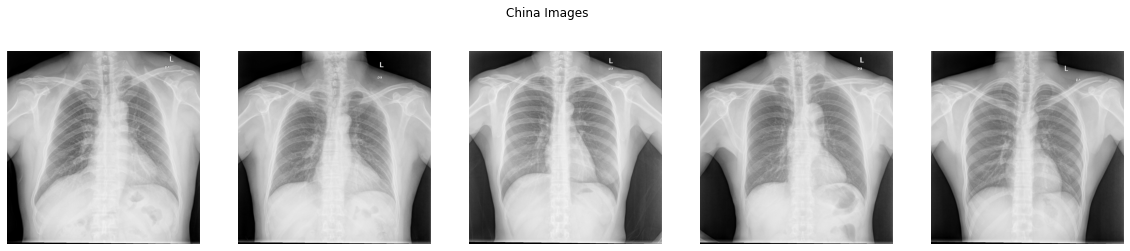

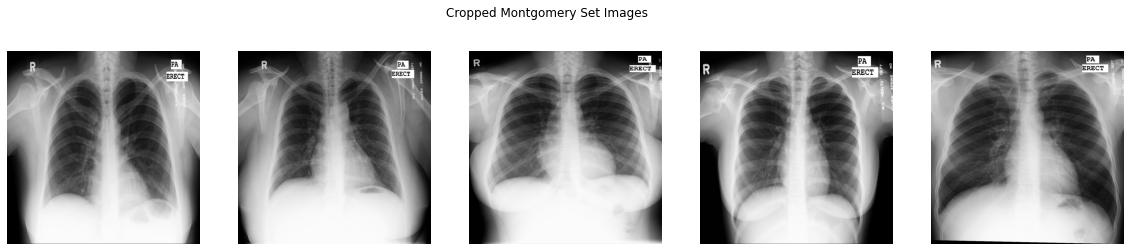

In [57]:
showImagesHorizontally(5,'/content/china/', 'China Images')
showImagesHorizontally(5, '/content/montgomery/', 'Cropped Montgomery Set Images')

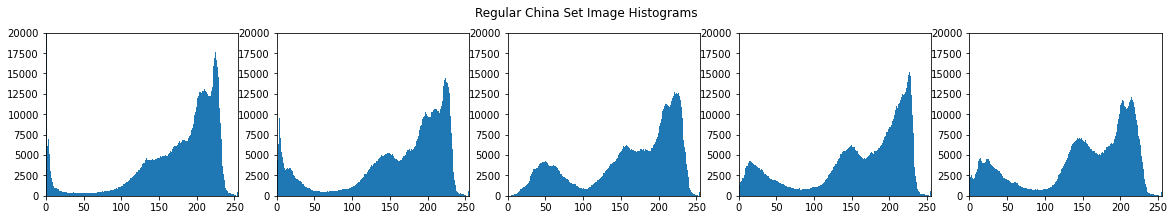

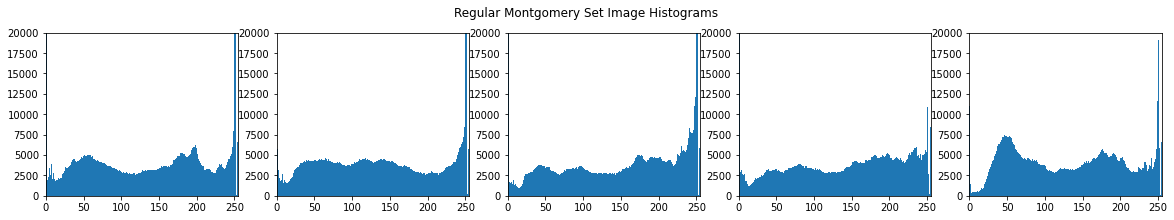

In [58]:
showImageHistograms(5, '/content/china/', 'Regular China Set Image Histograms')
showImageHistograms(5, '/content/montgomery/', 'Regular Montgomery Set Image Histograms')

In [92]:
def normalization(image_path,save_path,isTest):
  list_of_files = os.listdir(image_path)

  loop_range = 5 if isTest else len(list_of_files)

  for i in tqdm(range(loop_range)):

    img = cv2.imread(image_path + list_of_files[i])
    img = exposure.equalize_adapthist(img/np.max(img))
    img = exposure.rescale_intensity(img, out_range=(0, 255))


    cv2.imwrite(save_path + list_of_files[i], img)


In [90]:
!rm -r normalize_test_china/
!rm -r normalize_test_montgomery/

!mkdir normalize_test_china
!mkdir normalize_test_montgomery

In [93]:
normalization("/content/china/","/content/normalize_test_china/", False)
normalization("/content/montgomery/","/content/normalize_test_montgomery/", False)

100%|██████████| 138/138 [02:17<00:00,  1.01it/s]


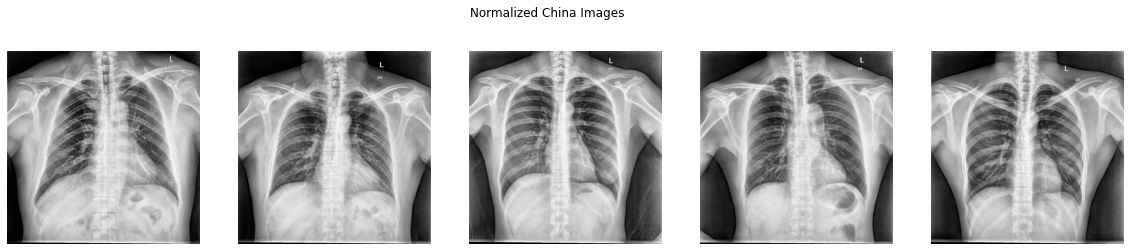

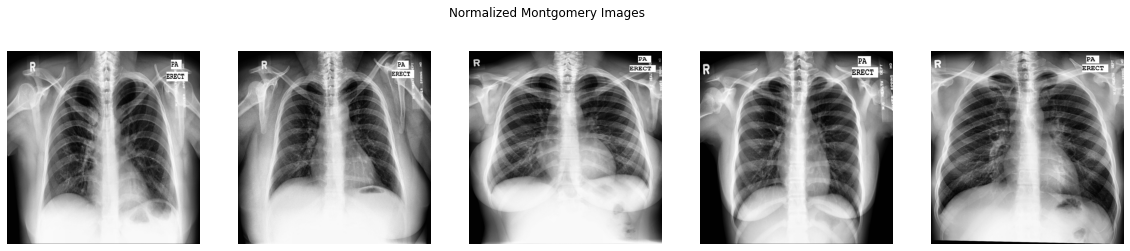

In [94]:
showImagesHorizontally(5,'/content/normalize_test_china/', 'Normalized China Images')
showImagesHorizontally(5,'/content/normalize_test_montgomery/', 'Normalized Montgomery Images')

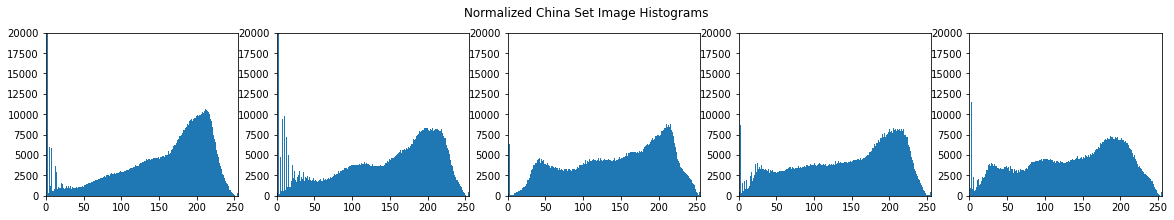

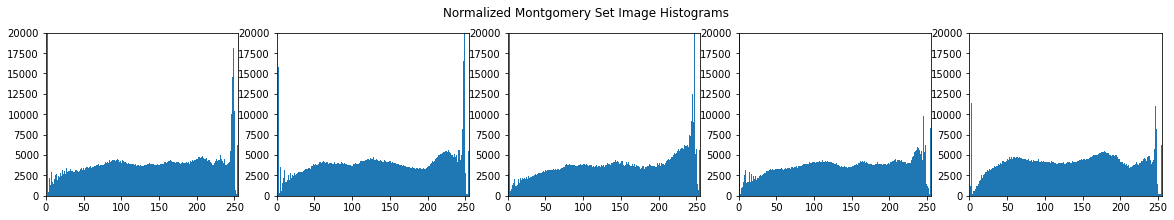

In [95]:
showImageHistograms(5, '/content/normalize_test_china/', 'Normalized China Set Image Histograms')
showImageHistograms(5, '/content/normalize_test_montgomery/', 'Normalized Montgomery Set Image Histograms')

In [82]:
OPENCV_METHODS = (
	("Correlation", cv2.HISTCMP_CORREL), # larger value = more similarity
	("Chi-Squared", cv2.HISTCMP_CHISQR), # smaller value = more similarity
	("Intersection", cv2.HISTCMP_INTERSECT), # larger value = more similarity
	("Hellinger", cv2.HISTCMP_BHATTACHARYYA)) # smaller value = more similarity

In [98]:
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/montgomery/', '/content/china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

100%|██████████| 138/138 [01:38<00:00,  1.40it/s]


Correlation 0.7743983350927491 0.0817221884398783


100%|██████████| 138/138 [01:38<00:00,  1.40it/s]


Chi-Squared 1.3522055358083476 0.6574595337726502


100%|██████████| 138/138 [01:38<00:00,  1.39it/s]


Intersection 1.7944368932191013 0.18623805678224287


100%|██████████| 138/138 [01:39<00:00,  1.39it/s]

Hellinger 0.271320536524453 0.049296713616526926


In [99]:
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/normalize_test_montgomery/', '/content/normalize_test_china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Correlation 0.883362057926253 0.06334258668621814


100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Chi-Squared 0.5871847419878072 0.32416298998933507


100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Intersection 2.17762886505628 0.17799281560854724


100%|██████████| 138/138 [01:43<00:00,  1.34it/s]

Hellinger 0.17116442987897768 0.05054477385313532
